## Decomposition of the Unitary Matrix

In [1]:
API_TOKEN = 'fc811ba08afd94a70b245b5be1337eda80f8a69f361e4d8018829c2dd9ca3ca32f7448eec2a5c3e9826daff089a73e63dc6c3be016972a5c495779a683c30ff7'

In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.classical import expr
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakePerth, FakeKyiv
from qiskit_ibm_runtime import SamplerV2
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_error_map, plot_distribution, circuit_drawer
from qiskit.result.mitigation import base_readout_mitigator

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set_style('dark')

In [3]:
def compute_von_neuman_from_memory(bit_results, error_correction=False, error_rates=None):
    s = []
    k = 0
    counts = {'0'*(4-len(bin(i)[2:]))+bin(i)[2:]:0 for i in range(16)}
    
    for idx, bit in enumerate(bit_results):
        if (idx+1)%10000 == 0:
            print(f'Shots : {idx+1}  ', end='\r')
        counts[bit.replace(" ", "")] += 1
        if error_correction:
            cnt_new = error_mitigation(counts, error_rates, shots=(idx+1))
            k = max(min(cnt_new['1100'] + cnt_new['1001'], 1), 0)
            s += [von_neumann_S_from_k(k)]
        else:
            if bit in ['1100', '1001', '1 0 0 1', '1 1 0 0']:
                k += 1       
            s += [(von_neumann_S_from_k(k/(idx+1)))]

    return s

                     
def entropy(p):
    if p==0 or p==1:
        return 0
    else:
        return -p*np.log2(p) -(1-p)*np.log2(1-p)


def von_neumann_S_from_k(k):
    if k>0.25:
        return 1
    if k<0:
        return 0
        
    t = np.sqrt(1-4*k)
    l1 = 0.5*(1+t)
    return entropy(l1)


def post_process(counts, error_rate, shots, n=16):
    s = 0
    counts_copy = counts.copy()
    for key in counts_copy:
        val = counts_copy[key]
        val = (val/shots - error_rate/n)/(1-error_rate)
        if val<0:
            val = 0
        counts_copy[key] = val
        s += val

    for key in counts_copy:
        counts_copy[key] /= s

    return counts_copy


def set_error(error_rates, xor_out):
    xor_out = bin(xor_out)[2:]
    xor_out = '0'*(4-len(xor_out)) + xor_out
    prod = 1
    for i in xor_out:
        prod *= (0.5+(-1)**int(i)*(0.5-error_rates[int(i)]))
    return prod


def error_mitigation(counts, error_rates, shots, n=16):
    r = range(16)
    A = np.zeros((16, 16))
    for i, row in enumerate(r):
        for j, col in enumerate(r):
            A[i, j] = set_error(error_rates, row^col)
            
    srt = sorted(counts)
    corrupted_probs = np.array([counts[i]/shots for i in srt]).reshape(16, 1)
    clean_estimate = np.linalg.inv(A)@corrupted_probs
    counts_new = {'0'*(4-len(bin(i)[2:])) + bin(i)[2:]:clean_estimate[i][0] for i in range(16)}
    return counts_new

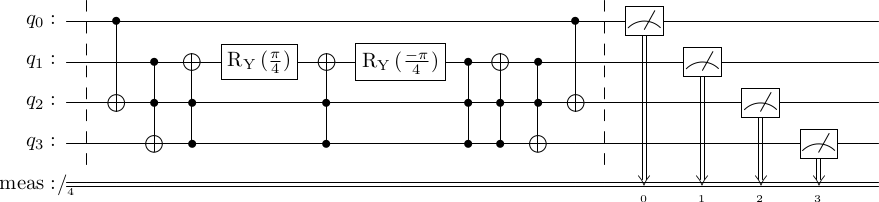

In [4]:
qc = QuantumCircuit(4)

# # Initialization
initial_state = Statevector(np.sqrt(0.5)*np.array([1, 0, 0, 1]))
tensor_state = initial_state^initial_state
# qc.initialize(tensor_state) # to initialize with any state

# qc.x(0)
# qc.x(1)
# qc.x(2)
# qc.x(3)

qc.barrier()
qc.cx(0, 2)
qc.ccx(1, 2, 3)
qc.ccx(3, 2, 1)
qc.ry(np.pi/4, 1)   #
qc.ccx(3, 2, 1)     # (For cch gate)   
qc.ry(-np.pi/4, 1)  #
qc.ccz(3, 2, 1)
qc.ccx(3, 2, 1)
qc.ccx(1, 2, 3)
qc.cx(0, 2)
qc.measure_all()

circuit_img = circuit_drawer(qc, output='mpl', filename='unitary_decomp.jpg', scale=2, style='iqp')
# circuit_img.savefig('unitary_decomp.jpg', )
qc.draw('latex')

In [ ]:
n = 100000

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, seed_transpiler=20)
isa_qc = pm.run(qc)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler()
#     result = sampler.run([isa_qc], shots=n).result()

job = aer_sim.run([isa_qc], shots=n, seed_simulator=20, memory=True)
result = job.result()
print(result.get_counts())

In [ ]:
n = 100000

backend = FakeManilaV2()
transpiled_circuit = transpile(qc, backend, optimization_level=0)

sampler = SamplerV2(backend)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler()
#     result = sampler.run([isa_qc], shots=n).result()

job = sampler.run([transpiled_circuit], shots=n)
pub_result = job.result()[0]
counts = pub_result.data.meas.get_counts()
plot_histogram(counts)

### LOCC Version

We just perform measurements on Alice's pair of qubits and the same circuit. We will use classical bits for control depending on the measurement values of Alice's qubits.

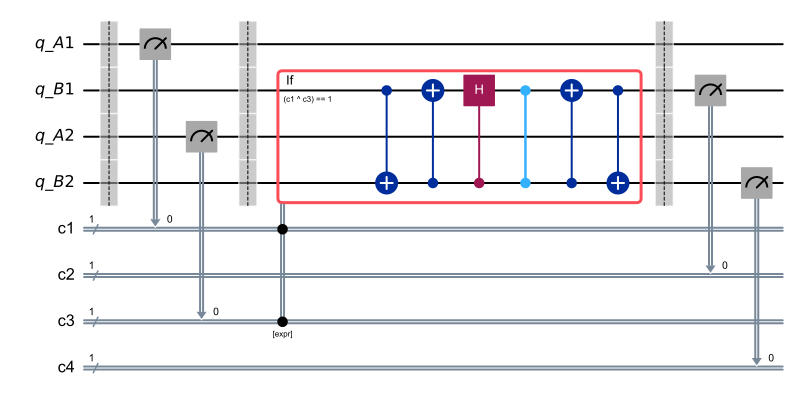

In [5]:
c1 = ClassicalRegister(1, name='c1')
c2 = ClassicalRegister(1, name='c2')
c3 = ClassicalRegister(1, name='c3')
c4 = ClassicalRegister(1, name='c4')
# cbits = ClassicalRegister(4, 'meas')
qa1 = QuantumRegister(1, name='q_A1')
qb1 = QuantumRegister(1, name='q_B1')
qa2 = QuantumRegister(1, name='q_A2')
qb2 = QuantumRegister(1, name='q_B2')

qc = QuantumCircuit(qa1, qb1, qa2, qb2, c1, c2, c3, c4)

# Initialization
initial_state = Statevector(np.sqrt(1/3)*np.array([1, 1, 0, 1]))
# initial_state = Statevector(np.sqrt(0.5)*np.array([1, 1, 0, 0]))
tensor_state = initial_state^initial_state
# qc.initialize(tensor_state) # to initialize with any state

# qc.x(0)
# # qc.x(1)
# qc.x(2)
# # qc.x(3)

qc.barrier()
qc.measure(0, 0)
qc.measure(2, 2)
qc.barrier()
# qc.cx(0, 2)

with qc.if_test(expr.equal(expr.bit_xor(c1, c3), 1)):
    # qc.x(0)

    qc.cx(1, 3)
    qc.cx(3, 1)
    # qc.ry(np.pi/4, 1)   #
    # qc.ccx(3, 2, 1)     # (For cch gate)   
    # qc.ry(-np.pi/4, 1)  #
    qc.ch(3, 1)
    qc.cz(3, 1)
    qc.cx(3, 1)
    qc.cx(1, 3)
    
# qc.cx(0, 2)
qc.barrier()
# qc.measure(0, 0)
qc.measure(1, 1)
# qc.measure(2, 2)
qc.measure(3, 3)

# circuit_img = circuit_drawer(qc, output='mpl', filename='locc_circ.jpg', scale=2, style='clifford')
qc.draw(output='mpl')

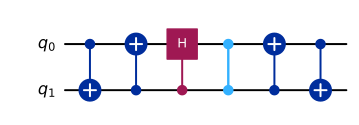

In [10]:
qcircuit = QuantumCircuit(2)
qcircuit.cx(0, 1)
qcircuit.cx(1, 0)
qcircuit.ch(1, 0)
qcircuit.cz(0, 1)
qcircuit.cx(1, 0)
qcircuit.cx(0, 1)

unitar = Operator(qcircuit).data
qcircuit.draw(output='mpl')

In [17]:
print(unitar)

[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j -0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]]


In [21]:
gt = UnitaryGate(unitar)

In [24]:
dc = QuantumCircuit(2)
dc.append(gt, [0, 1])

dc.draw()

┌──────────┐
q_0: ┤0         ├
     │  Unitary │
q_1: ┤1         ├
     └──────────┘

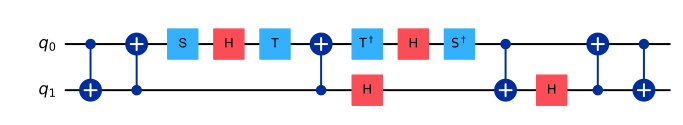

In [25]:
qcircuit.decompose().draw(output='mpl')

In [13]:
dc = qcircuit.decompose()

In [14]:
print(dc)

          ┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐┌─────┐          ┌───┐     
q_0: ──■──┤ X ├┤ S ├┤ H ├┤ T ├┤ X ├┤ Tdg ├┤ H ├┤ Sdg ├──■───────┤ X ├──■──
     ┌─┴─┐└─┬─┘└───┘└───┘└───┘└─┬─┘└┬───┬┘└───┘└─────┘┌─┴─┐┌───┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■───────────────────■───┤ H ├─────────────┤ X ├┤ H ├──■──┤ X ├
     └───┘                          └───┘             └───┘└───┘     └───┘


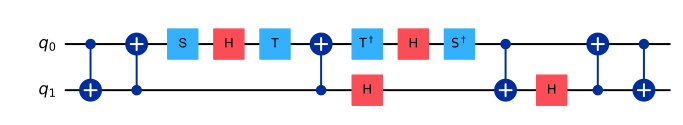

In [15]:
dc.draw(output='mpl')

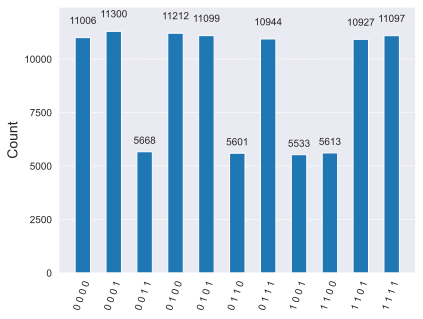

In [13]:
n = 100000
aer_sim = AerSimulator(shots=1000)
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3, seed_transpiler=20)
isa_qc = pm.run(qc)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler()
#     result = sampler.run([isa_qc], shots=n).result()

job = aer_sim.run([isa_qc], shots=n, seed_simulator=30, memory=True)
result = job.result()
memory_aer = result.get_memory()
plot_histogram(result.get_counts())

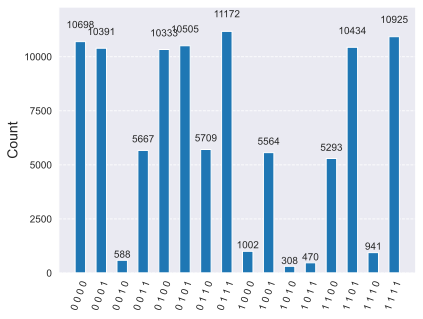

In [16]:
n = 100000

# backend = FakeManilaV2()
backend = FakeKyiv()
# backend = FakePerth()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=20)
isa_qc = pm.run(qc)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler()
#     result = sampler.run([isa_qc], shots=n).result()

job = backend.run([isa_qc], shots=n, seed_simulator=30, memory=True)
result = job.result()
memory = result.get_memory()
plot_histogram(result.get_counts())

In [15]:
error_rates1 = [backend.target['measure'][(i,)].error for i in range(4)]

In [11]:
error_rates1

[0.0353, 0.02190000000000003, 0.09640000000000004, 0.014399999999999968]

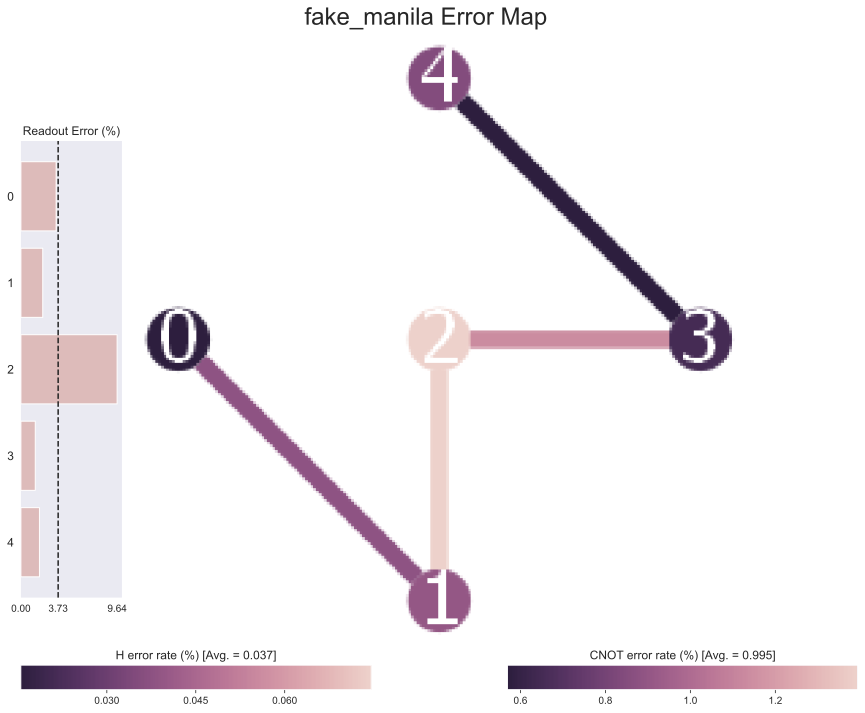

In [12]:
plot_error_map(backend)

In [13]:
cnt = result.get_counts()

In [14]:
memory = result.get_memory()

In [15]:
cnt_new = error_mitigation(cnt, error_rates1, 100000)

In [16]:
s = 0
for i in cnt_new:
    s += cnt_new[i]

print(s)

1.055444875232806


In [274]:
cnt_new

{'0000': np.float64(0.11559751100710933),
 '0001': np.float64(0.11795239708407569),
 '0010': np.float64(0.016939726374290802),
 '0011': np.float64(0.061580094057514766),
 '0100': np.float64(0.11006172227899924),
 '0101': np.float64(0.11659241515183791),
 '0110': np.float64(0.060579466275964694),
 '0111': np.float64(0.10398693762493146),
 '1000': np.float64(0.00846670970126285),
 '1001': np.float64(0.051531272581910356),
 '1010': np.float64(0.003481711258398041),
 '1011': np.float64(0.007431165936642603),
 '1100': np.float64(0.054934201632652745),
 '1101': np.float64(0.11100149616259089),
 '1110': np.float64(0.01505118212615006),
 '1111': np.float64(0.10025686597847454)}

In [277]:
k = cnt_new['1100'] + cnt_new['1001']
# k = (cnt['1 1 0 0'] + cnt['1 0 0 1'])/100000

In [278]:
von_neumann_S_from_k(k)

np.float64(0.53263031719179)

In [88]:
compute_von_neuman_from_memory(memory, error_correction=True, error_rates=error_rates)

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 np.float64(0.9921787434708594),
 np.float64(0.9406531475242734),
 np.float64(0.8949366535183261),
 1,
 1,
 np.float64(0.9715111829718143),
 np.float64(0.9344037899311821),
 np.float64(0.9004257618388036),
 np.float64(0.8691793106657419),
 np.float64(0.9979800199586994),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 np.float64(0.9946375418945317),
 np.float64(0.9878880785078645),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 np.float64(0.9955321804412218),
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 np.float64(0.996923053636704

In [17]:
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService

In [18]:
service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [19]:
backend = service.backend('ibm_kyiv')

In [18]:
# backend.target['measure'][(3,)]

In [19]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=20)
isa_qc = pm.run(qc)

In [20]:
sampler = SamplerV2(backend)
job = sampler.run([isa_qc], shots=100000)
print(f"job id: {job.job_id()}")

job id: cwngejtmptp0008696n0


In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='fc811ba08afd94a70b245b5be1337eda80f8a69f361e4d8018829c2dd9ca3ca32f7448eec2a5c3e9826daff089a73e63dc6c3be016972a5c495779a683c30ff7'
)
job = service.job('cwngejtmptp0008696n0')
pub_result = job.result()[0]

In [300]:
error_rates = [np.std([backend.target['measure'][(i,)].error for i in range(0, 126)])]*4

In [301]:
error_rates

[np.float64(0.027055862072046005),
 np.float64(0.027055862072046005),
 np.float64(0.027055862072046005),
 np.float64(0.027055862072046005)]

In [19]:
def post_process_ibmq(pub_result):
    measurement = dict()
    memory_register = list()
    for key in pub_result.data.keys():
        memory_register += [pub_result.data[key].get_bitstrings()]

    memory_pr = list()
    for idx in range(len(memory_register[0])):
        string = ''
        for reg in memory_register[::-1]:
            string += reg[idx]
        memory_pr.append(string)    

    return memory_pr

In [20]:
memory_ibmq = post_process_ibmq(pub_result)

In [21]:
s_noisy_sim = np.array(compute_von_neuman_from_memory(memory))
# s_noisy_em = np.array(compute_von_neuman_from_memory(memory, error_correction=True, error_rates=error_rates1))
s_noiseless = np.array(compute_von_neuman_from_memory(memory_aer))
s_ibm_backend = np.array(compute_von_neuman_from_memory(memory_ibmq))
# s_ibm_em = np.array(compute_von_neuman_from_memory(memory_ibmq, error_correction=True, error_rates=error_rates))
true = von_neumann_S_from_k(1/9)

In [23]:
### FOR PPT
def estimate_bounds_from_memory(memory, error_prob):
    probs = np.ones(len(memory))
    n = np.array(range(1, len(memory)+1))
    k = 0
    
    for idx, el in enumerate(memory):
        if el in ['1 0 0 1', '1001', '1100', '1 1 0 0']:
            k += 1
        probs[idx] = k/(idx+1)

    bound = np.sqrt(3*np.log(2/error_prob)/(8*n))
    ucb = probs + bound
    lcb = probs - bound

    return ucb, lcb

In [24]:
ucb, lcb = estimate_bounds_from_memory(memory_aer, error_prob=0.01)
ucb_weak, lcb_weak = estimate_bounds_from_memory(memory_aer, error_prob=0.3)
s_noiseless = np.array(compute_von_neuman_from_memory(memory_aer))
s_lcb = np.array([von_neumann_S_from_k(l) for l in lcb])
s_ucb = np.array([von_neumann_S_from_k(u) for u in ucb])
s_lcb_weak = np.array([von_neumann_S_from_k(l) for l in lcb_weak])
s_ucb_weak = np.array([von_neumann_S_from_k(u) for u in ucb_weak])
true = von_neumann_S_from_k(1/9)

In [35]:
plt.plot(range(n), s_noiseless, color='blue', label='Estimated Entropy')
plt.fill_between(range(n), s_lcb, s_ucb, alpha=0.7, label='Confidence Interval $(\delta=0.01)$')
# plt.fill_between(range(n), s_lcb_weak, s_ucb_weak, alpha=0.4, label='Confidence Interval $(\delta=0.3)$')
plt.axhline(true, ls='dashed', color='red', label='True Entropy Value', alpha=0.7)
plt.grid()
plt.grid(which='minor', ls=':', lw=0.5)
plt.minorticks_on()
plt.ylim(0,1)
plt.xlabel("No. of Rounds", labelpad=10, fontsize=13)
plt.ylabel("Entanglement Entropy", labelpad=10, fontsize=13)
# plt.title("Entanglement Entropy vs Rounds", pad=10, size=13)
plt.legend(fontsize=11)
plt.savefig('entropy_estimation_experiment_1.jpg', dpi=500, bbox_inches='tight')
plt.show()

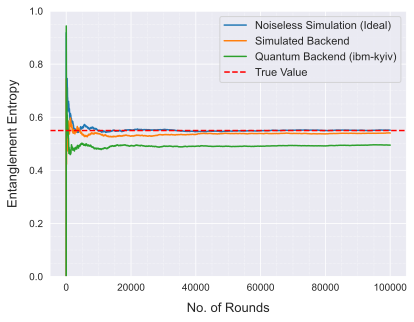

In [22]:
plt.plot(range(n), s_noiseless, label='Noiseless Simulation (Ideal)')
plt.plot(range(n), s_noisy_sim, label='Simulated Backend')
# plt.plot(range(n), s_noisy_em, label='Simulated Backend with Error Correction')
plt.plot(range(n), s_ibm_backend, label='Quantum Backend (ibm-kyiv)')
# plt.plot(range(n), s_ibm_em, label='True Quantum Backend with Error Correction')
plt.axhline(true, ls='dashed', c='red', label='True Value')
plt.ylim(0,1)
plt.grid()
plt.grid(which='minor', ls=':', lw=0.5)
plt.minorticks_on()
plt.xlabel("No. of Rounds", labelpad=10, fontsize=13)
plt.ylabel("Entanglement Entropy", labelpad=10, fontsize=13)
# plt.title("Entanglement Entropy vs Rounds", pad=10, size=13)
plt.legend(fontsize=11)
# plt.savefig('entropy_estimation_experiment_2.jpg', dpi=500, bbox_inches='tight')
plt.show()

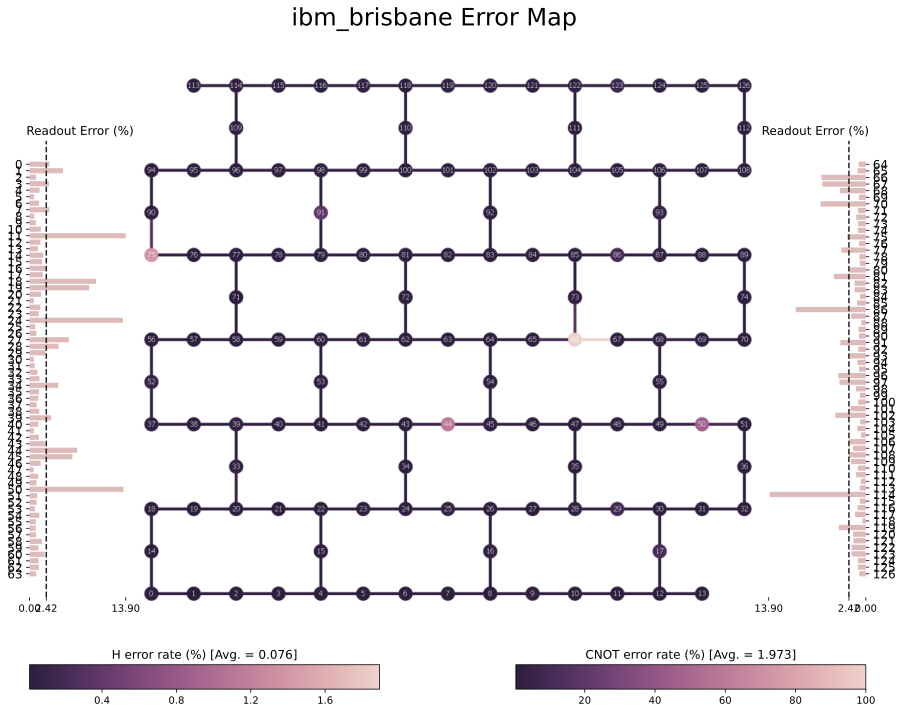

In [290]:
plot_error_map(backend)

### Error Bounds :
Hoeffding's Concentration Bounds

We need $\mathcal{O}(\frac{\log(\frac{1}{\delta})}{\epsilon^2})$ samples to estimate $|K|^2$ upto an accuracy of $\epsilon$ with probability $1-\delta$

$$ \mathbb{P}(||\hat{K}|^2 - |K|^2| \geq \epsilon) \leq 2\exp(-2n\epsilon^2) $$

No. of Rounds:

$$ n \geq \dfrac{\log(\frac{2}{\delta})}{2\epsilon^2}$$

We have $ n_{\text{copies}} = 2n $

No. of copies:

$$ n_{\text{copies}} \geq \dfrac{\log(\frac{2}{\delta})}{\epsilon^2}$$

In [86]:
def hoeffding_bound(error_prob, n):
    return np.sqrt((3/8)*np.log(2/error_prob)*(1/n))

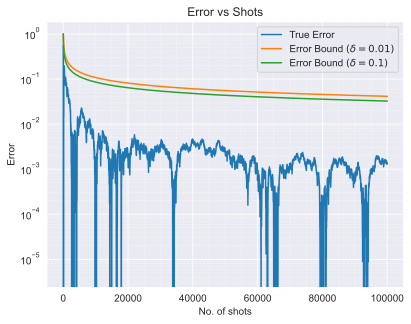

In [87]:
error_prob = 0.01
n = np.array(range(1, 100000+1))
err = abs(s_noiseless - true)
bound = [von_neumann_S_from_k(hoeffding_bound(error_prob, i)) for i in n]
bound2 = [von_neumann_S_from_k(hoeffding_bound(0.1, i)) for i in n]

plt.semilogy(n, err, label='True Error')
plt.semilogy(n, bound, label='Error Bound $(\delta = 0.01)$')
plt.semilogy(n, bound2, label='Error Bound $(\delta = 0.1)$')
plt.grid()
plt.grid(which='minor', ls=':', lw=0.5)
plt.minorticks_on()
plt.xlabel("No. of shots")
plt.ylabel("Error")
plt.title("Error vs Shots")
plt.legend()
plt.savefig('Error_Bounds.jpg', dpi=500)
plt.show()

## Quantum Amplitude Estimation

In [12]:
from qiskit_algorithms import IterativeAmplitudeEstimation
from qiskit_algorithms.amplitude_estimators import EstimationProblem
from qiskit.circuit.library import GroverOperator
from qiskit.circuit.library import StatePreparation
from qiskit.primitives import Sampler

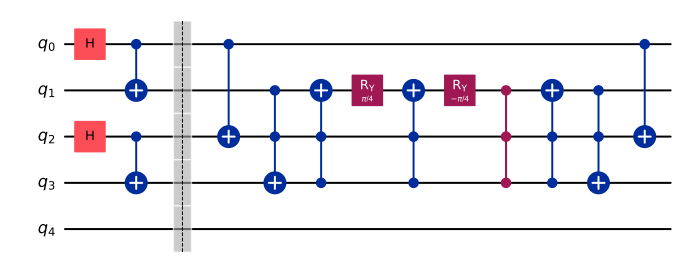

In [40]:
qc = QuantumCircuit(5)

# Initialization
# initial_state = Statevector(np.sqrt(0.5)*np.array([1, 0, 0, 1]))
# tensor_state = initial_state^initial_state
# qc.initialize(tensor_state) # to initialize with any state

# qc.ry(np.pi/8, 0)
qc.h(0)
qc.cx(0, 1)
# qc.x(1)
# qc.ry(np.pi/8, 2)
qc.h(2)
qc.cx(2,3)
# qc.x(3)

qc.barrier()
qc.cx(0, 2)
qc.ccx(1, 2, 3)
qc.ccx(3, 2, 1)
qc.ry(np.pi/4, 1)   #
qc.ccx(3, 2, 1)     # (For cch gate)   
qc.ry(-np.pi/4, 1)  #
qc.ccz(3, 2, 1)
qc.ccx(3, 2, 1)
qc.ccx(1, 2, 3)
qc.cx(0, 2)
# qc.measure_all()

qc.draw('mpl')

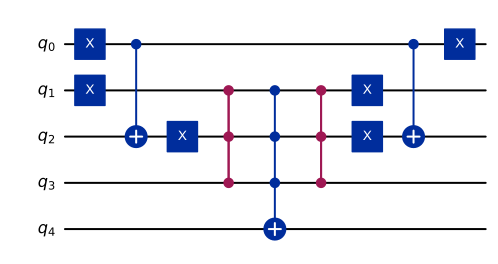

In [52]:
initial_state = Statevector(1/np.sqrt(2)*np.array([1, 0, 0, 1]))
tensor_state = initial_state^initial_state

oracle_qc = QuantumCircuit(5)
oracle_qc.x(0)
oracle_qc.x(1)
oracle_qc.cx(0, 2)
oracle_qc.x(2)
oracle_qc.ccz(1, 2, 3)
oracle_qc.mcx([1,2,3], 4)
oracle_qc.ccz(1, 2, 3)
oracle_qc.x(2)
oracle_qc.cx(0, 2)
oracle_qc.x(0)
oracle_qc.x(1)
sv = Statevector(oracle_qc)
oracle_qc.draw('mpl')

In [53]:
sv.draw('latex')

<IPython.core.display.Latex object>

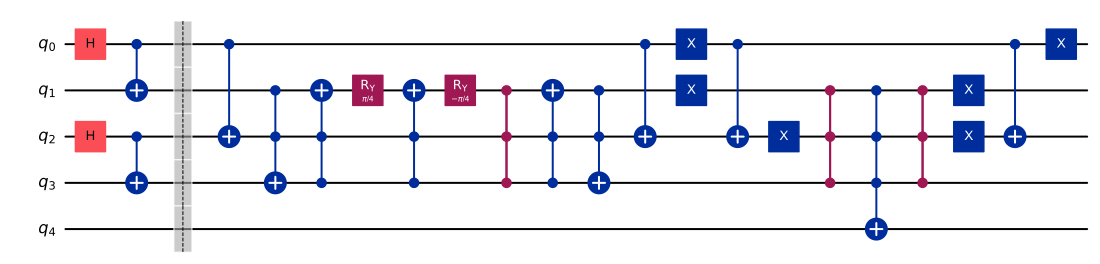

In [54]:
qc_new = qc.compose(oracle_qc)
sv = Statevector(qc_new)
qc_new.draw('mpl')

In [51]:
sv.draw('latex')

<IPython.core.display.Latex object>

In [55]:
grover_op = GroverOperator(oracle=oracle_qc, state_preparation=qc)

In [56]:
aer_sim = AerSimulator()
transpiled_qc = transpile(qc, backend=aer_sim, optimization_level=3)

In [73]:
problem = EstimationProblem(
    state_preparation=transpiled_qc,
    grover_operator=grover_op,
    objective_qubits=[4]  # Assume the amplitude of interest affects qubit 4
)

In [74]:
sampler = Sampler()
iqae = IterativeAmplitudeEstimation(epsilon_target=0.1, alpha=0.05, sampler=sampler)

C:\Users\Jai\AppData\Local\Temp\ipykernel_12032\2285751684.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [75]:
result = iqae.estimate(problem)

In [76]:
print("Estimated amplitude:", result.estimation)
print("Confidence interval:", result.confidence_interval)

Estimated amplitude: 0.0
Confidence interval: [0.0, 0.0]


In [220]:
result.estimation/t

np.float64(2.2860997046291542)

In [219]:
t = np.sqrt(np.cos(np.pi/16)*np.sin(np.pi/16))

## Readout Error Mitigation


In [33]:
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

In [34]:
# qubits = list(range2, 6))
qubits = [1, 2, 3, 4]

In [35]:
exp = LocalReadoutError(qubits)

In [36]:
exp.transpile_options.optimization_level = 3

In [37]:
exp.transpile_options

Options(optimization_level=3)

In [57]:
sampler = SamplerV2(backend)

In [65]:
exp.analysis.set_options(plot=True, shots=10000)
result = exp.run(backend, sampler)

In [66]:
mitigator = result.analysis_results("Local Readout Mitigator").value

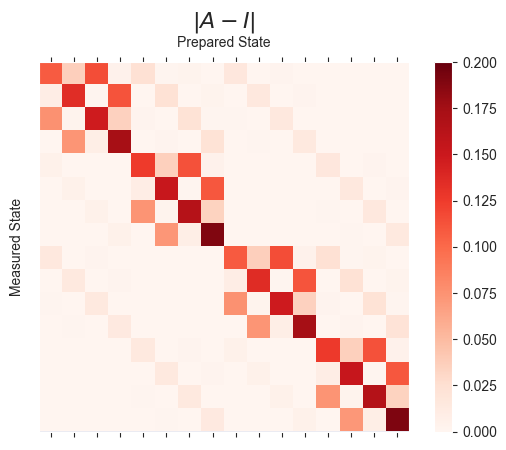

In [67]:
result.figure(0)

In [204]:
unmitigated_probs = {label: count / 100000 for label, count in cnt.items()}
mitigated_quasi_probs = mitigator.quasi_probabilities(cnt)

In [205]:
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

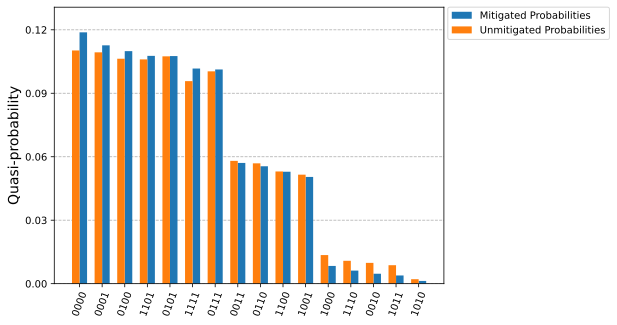

In [206]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_distribution([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

In [207]:
k = mitigated_quasi_probs[12] + mitigated_quasi_probs[9]
von_neumann_S_from_k(k)

np.float64(0.5208345906185776)

In [132]:
cnt = {i.replace(" ", ''):cnt[i] for i in cnt}

## Error Mitigation 

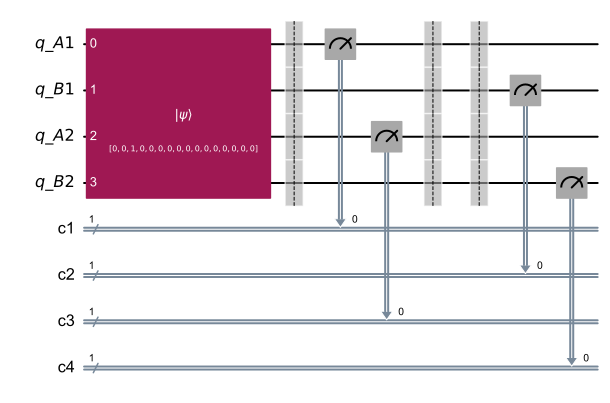

In [70]:
c1 = ClassicalRegister(1, name='c1')
c2 = ClassicalRegister(1, name='c2')
c3 = ClassicalRegister(1, name='c3')
c4 = ClassicalRegister(1, name='c4')
# cbits = ClassicalRegister(4, 'meas')
qa1 = QuantumRegister(1, name='q_A1')
qb1 = QuantumRegister(1, name='q_B1')
qa2 = QuantumRegister(1, name='q_A2')
qb2 = QuantumRegister(1, name='q_B2')

qc = QuantumCircuit(qa1, qb1, qa2, qb2, c1, c2, c3, c4)

# Initialization
# initial_state = Statevector(np.array([1, 0, 0, 0]))
# initial_state = Statevector(np.sqrt(0.5)*np.array([1, 1, 0, 0]))
state = np.zeros(16)
state[2] = 1 
tensor_state = Statevector(state)
qc.initialize(tensor_state) # to initialize with any state

# qc.x(0)
# # qc.x(1)
# qc.x(2)
# # qc.x(3)

qc.barrier()
qc.measure(0, 0)
qc.measure(2, 2)
qc.barrier()
# qc.cx(0, 2)

# with qc.if_test(expr.equal(expr.bit_xor(c1, c3), 1)):
#     # qc.x(0)

#     qc.cx(1, 3)
#     qc.cx(3, 1)
#     # qc.ry(np.pi/4, 1)   #
#     # qc.ccx(3, 2, 1)     # (For cch gate)   
#     # qc.ry(-np.pi/4, 1)  #
#     qc.ch(3, 1)
#     qc.cz(3, 1)
#     qc.cx(3, 1)
#     qc.cx(1, 3)
    
# qc.cx(0, 2)
qc.barrier()
# qc.measure(0, 0)
qc.measure(1, 1)
# qc.measure(2, 2)
qc.measure(3, 3)
qc.draw('mpl')

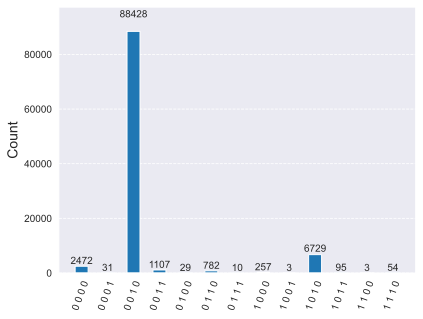

In [71]:
n = 100000

backend = FakeKyiv()
# backend = FakePerth()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=20)
isa_qc = pm.run(qc)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler()
#     result = sampler.run([isa_qc], shots=n).result()

job = backend.run([isa_qc], shots=n, seed_simulator=30, memory=True)
result = job.result()
memory = result.get_memory()
plot_histogram(result.get_counts())

In [23]:
A_matrix = []
n = 100000
states = ['0 0 0 0', '0 0 0 1', '0 0 1 0', '0 0 1 1',
          '0 1 0 0', '0 1 0 1', '0 1 1 0', '0 1 1 1',
          '1 0 0 0', '1 0 0 1', '1 0 1 0', '1 0 1 1',
          '1 1 0 0', '1 1 0 1', '1 1 1 0', '1 1 1 1']

for idx in range(16):
    c1 = ClassicalRegister(1, name='c1')
    c2 = ClassicalRegister(1, name='c2')
    c3 = ClassicalRegister(1, name='c3')
    c4 = ClassicalRegister(1, name='c4')
    # cbits = ClassicalRegister(4, 'meas')
    qa1 = QuantumRegister(1, name='q_A1')
    qb1 = QuantumRegister(1, name='q_B1')
    qa2 = QuantumRegister(1, name='q_A2')
    qb2 = QuantumRegister(1, name='q_B2')
    
    qc = QuantumCircuit(qa1, qb1, qa2, qb2, c1, c2, c3, c4)
    
    # Initialization
    # initial_state = Statevector(np.array([1, 0, 0, 0]))
    # initial_state = Statevector(np.sqrt(0.5)*np.array([1, 1, 0, 0]))
    state = np.zeros(16)
    state[idx] = 1 
    tensor_state = Statevector(state)
    qc.initialize(tensor_state) # to initialize with any state
    
    # qc.x(0)
    # # qc.x(1)
    # qc.x(2)
    # # qc.x(3)
    
    qc.barrier()
    qc.measure(0, 0)
    qc.measure(2, 2)
    qc.barrier()
    # qc.cx(0, 2)
    
    # with qc.if_test(expr.equal(expr.bit_xor(c1, c3), 1)):
    #     # qc.x(0)
    
    #     qc.cx(1, 3)
    #     qc.cx(3, 1)
    #     # qc.ry(np.pi/4, 1)   #
    #     # qc.ccx(3, 2, 1)     # (For cch gate)   
    #     # qc.ry(-np.pi/4, 1)  #
    #     qc.ch(3, 1)
    #     qc.cz(3, 1)
    #     qc.cx(3, 1)
    #     qc.cx(1, 3)
        
    # qc.cx(0, 2)
    qc.barrier()
    # qc.measure(0, 0)
    qc.measure(1, 1)
    # qc.measure(2, 2)
    qc.measure(3, 3)
    qc.draw('mpl')

    backend = FakeKyiv()
    # backend = FakePerth()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=10)
    isa_qc = pm.run(qc)
    # with Session(backend=aer_sim) as session:
    #     sampler = Sampler()
    #     result = sampler.run([isa_qc], shots=n).result()
    
    job = backend.run([isa_qc], shots=n, seed_simulator=20, memory=True)
    result = job.result()
    memory = result.get_memory()
    counts = result.get_counts()

    
    temp = []
    for state in states:
        if state in counts:
            temp += [counts[state]/n]
        else:
            temp += [0]
    A_matrix.append(temp)
        
    

In [24]:
noise_inv = np.linalg.inv(np.array(A_matrix).T)

In [25]:
c1 = ClassicalRegister(1, name='c1')
c2 = ClassicalRegister(1, name='c2')
c3 = ClassicalRegister(1, name='c3')
c4 = ClassicalRegister(1, name='c4')
# cbits = ClassicalRegister(4, 'meas')
qa1 = QuantumRegister(1, name='q_A1')
qb1 = QuantumRegister(1, name='q_B1')
qa2 = QuantumRegister(1, name='q_A2')
qb2 = QuantumRegister(1, name='q_B2')

qc = QuantumCircuit(qa1, qb1, qa2, qb2, c1, c2, c3, c4)

# Initialization
initial_state = Statevector(np.sqrt(1/3)*np.array([1, 1, 0, 1]))
# initial_state = Statevector(np.sqrt(0.5)*np.array([1, 1, 0, 0]))
# state = np.zeros(16)
# state[idx] = 1 
tensor_state = initial_state^initial_state
qc.initialize(tensor_state) # to initialize with any state

# qc.x(0)
# # qc.x(1)
# qc.x(2)
# # qc.x(3)

qc.barrier()
qc.measure(0, 0)
qc.measure(2, 2)
qc.barrier()
# qc.cx(0, 2)

with qc.if_test(expr.equal(expr.bit_xor(c1, c3), 1)):
    # qc.x(0)

    qc.cx(1, 3)
    qc.cx(3, 1)
    # qc.ry(np.pi/4, 1)   #
    # qc.ccx(3, 2, 1)     # (For cch gate)   
    # qc.ry(-np.pi/4, 1)  #
    qc.ch(3, 1)
    qc.cz(3, 1)
    qc.cx(3, 1)
    qc.cx(1, 3)
    
# qc.cx(0, 2)
qc.barrier()
# qc.measure(0, 0)
qc.measure(1, 1)
# qc.measure(2, 2)
qc.measure(3, 3)
qc.draw('mpl')

backend = FakeManilaV2()
# backend = FakePerth()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=10)
isa_qc = pm.run(qc)
# with Session(backend=aer_sim) as session:
#     sampler = Sampler()
#     result = sampler.run([isa_qc], shots=n).result()

job = backend.run([isa_qc], shots=n, seed_simulator=21, memory=True)
result = job.result()
memory = result.get_memory()
counts = result.get_counts()

In [26]:
def get_prob(counts, n):
    prob = []
    for state in states:
        if state in counts:
            prob += [counts[state]/n]
        else:
            prob += [0]
    return prob

In [27]:
def get_reverse_map(prob):
    reverse_map = {}
    for idx, el in enumerate(prob):
        reverse_map[states[idx]] = el
    return reverse_map

In [28]:
p_get = get_prob(counts, n)

In [29]:
get_reverse_map(p_get)

{'0 0 0 0': 0.10526,
 '0 0 0 1': 0.10911,
 '0 0 1 0': 0.01959,
 '0 0 1 1': 0.05838,
 '0 1 0 0': 0.10234,
 '0 1 0 1': 0.10988,
 '0 1 1 0': 0.05752,
 '0 1 1 1': 0.0969,
 '1 0 0 0': 0.01194,
 '1 0 0 1': 0.04966,
 '1 0 1 0': 0.00416,
 '1 0 1 1': 0.01087,
 '1 1 0 0': 0.05259,
 '1 1 0 1': 0.10263,
 '1 1 1 0': 0.01751,
 '1 1 1 1': 0.09166}

In [30]:
p_noise_mitigated = noise_inv.T@np.array(p_get)

In [31]:
get_reverse_map(p_noise_mitigated)

{'0 0 0 0': np.float64(0.10558874964523575),
 '0 0 0 1': np.float64(0.11098691130273655),
 '0 0 1 0': np.float64(0.01829537005820777),
 '0 0 1 1': np.float64(0.058172758133513275),
 '0 1 0 0': np.float64(0.1025777620650702),
 '0 1 0 1': np.float64(0.11168689039571028),
 '0 1 1 0': np.float64(0.057515812403606294),
 '0 1 1 1': np.float64(0.100679544549587),
 '1 0 0 0': np.float64(0.010956120031054103),
 '1 0 0 1': np.float64(0.05080242421838869),
 '1 0 1 0': np.float64(0.0036992570386825256),
 '1 0 1 1': np.float64(0.008582840285669987),
 '1 1 0 0': np.float64(0.05236279492514939),
 '1 1 0 1': np.float64(0.10593389904570422),
 '1 1 1 0': np.float64(0.015829098922563324),
 '1 1 1 1': np.float64(0.09869644934909684)}

In [172]:
k = (519 + 575)/10000

In [173]:
von_neumann_S_from_k(1/9)

np.float64(0.5500477595827576)

In [174]:
von_neumann_S_from_k(k)

np.float64(0.5436580185283444)

In [107]:
get_reverse_map(p_get)

{'0 0 0 0': 0.1044,
 '0 0 0 1': 0.1112,
 '0 0 1 0': 0.0192,
 '0 0 1 1': 0.0564,
 '0 1 0 0': 0.1025,
 '0 1 0 1': 0.1103,
 '0 1 1 0': 0.0553,
 '0 1 1 1': 0.0967,
 '1 0 0 0': 0.0122,
 '1 0 0 1': 0.0491,
 '1 0 1 0': 0.004,
 '1 0 1 1': 0.0114,
 '1 1 0 0': 0.0528,
 '1 1 0 1': 0.1053,
 '1 1 1 0': 0.0176,
 '1 1 1 1': 0.0916}

In [110]:
von_neumann_S_from_k(0.0528 + 0.0491)

np.float64(0.5152934961756679)